## Analysis

In this notebook, you will learn how to interpret the light curve of a start.

Requisites:
* a working Python 3.x environment, with **Astropy** (4.0), **Matplotlib** (3.1), **NumPy** (1.18), and **SciPy** (1.4) installed;
* a ```utils.py``` file with useful functions;
* a table with the magnitudes measured from a set of science frames (e.g. ```sci_2015/mags.fits```).

### Let's make the light curve

We can load up the magnitudes we have previously measured and format them as an Astropy table: 

In [1]:
from astropy.io import fits
from astropy.table import Table
mags = Table(fits.open('FINAL_1/SZ_Lyn_V_wr_to_average.fits')[1].data)
print(mags)

       file           magnitude             error                time       
----------------- ----------------- --------------------- ------------------
SZ_Lyn-0001_V.fit 9.437831435189498 0.0014076205394378883 2459660.3223783583
SZ_Lyn-0002_V.fit 9.441592196971756 0.0012623300393539792 2459660.3236514116
SZ_Lyn-0003_V.fit 9.453173479769807 0.0012752849800540863 2459660.3249244546
SZ_Lyn-0004_V.fit 9.455698375570327 0.0013519060254516616 2459660.3261977406
SZ_Lyn-0005_V.fit 9.519342887971389 0.0012959819361056909 2459660.3274589563
SZ_Lyn-0006_V.fit 9.479367671208312 0.0013292686944983833 2459660.3287320095
SZ_Lyn-0007_V.fit 9.475410813826336 0.0013867741321965416  2459660.330016615
SZ_Lyn-0008_V.fit 9.521176873802075 0.0012688302562793396  2459660.331278085
SZ_Lyn-0009_V.fit 9.502259791169612 0.0013013069456822863  2459660.332551138
SZ_Lyn-0010_V.fit  9.50841685508243 0.0014272381402677357   2459660.33382416
              ...               ...                   ...                ...

We need to relate each magnitude value with the time of observation, which is provided in Julian Day format in the frame headers:

In [2]:
import numpy as np



Now we can properly plot the light curve of the star and save it:

(242,) (242,)


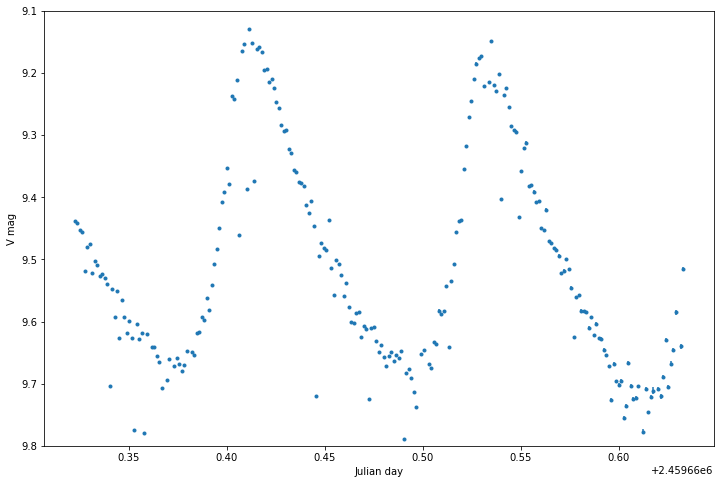

In [20]:
def setup_plot(figsize, xlabel, ylabel):
    """ @brief Initialize basic plot parameters
        @param figsize Figure size
        @param xlabel X-axis label
        @param ylabel Y-axis label
    """

    plt.figure(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
import matplotlib.pyplot as plt

jd=[]
mag=[]
mag_err=[]
for i in range (0, len(list(mags['magnitude']))):
    if not np.isnan(mags['magnitude'][i]):
        if not np.isnan(mags['error'][i]):
            jd.append(float(mags['time'][i]))
            mag.append(float(mags['magnitude'][i]))
            mag_err.append(float(mags['error'][i])) 
jd=np.array(jd)
mag=np.array(mag)
mag_err=np.array(mag_err)
print(mag.shape, mag_err.shape)
setup_plot((12,8), 'Julian day', 'V mag')
plt.errorbar(jd, mag, mag_err, fmt='.')
plt.ylim(9.8, 9.1)
plt.show()

t = Table([jd, mag, mag_err], names=['jd', 'V', 'V_err'])
t.write('mags_jd.fits', format='fits', overwrite=True)


## Timing the fluctuations

A simple way to measure the period is to slide the light curve over itself along the time axis. We expect that the auto-correlation to be 1 at start (before sliding the curve) and to reach a maximum at some point, when the curve has been slid by exactly one period.

We use ```pearson``` from SciPy to compute the Pearson correlation coefficient. Of course, when the curve is slid, the region where it overlaps with the original curve shrinks down, increasing the error on the correlation coefficient.

In [29]:
from scipy.stats import pearsonr


r = np.array([])
dr = np.array([])

td = jd-jd[0]  # Time since start [d]
mag_norm = -2*(mag-0.5*(np.nanmax(mag)+np.nanmin(mag)))/(np.nanmax(mag)-np.nanmin(mag))  # Normalized V mag
mag_norm2 = 0.5*(mag_norm+1)*(np.nanmax(td)-np.nanmin(td))

for i in range(len(mag)):
    
    

    if i>0 and len(mag[i:])>2:  # Cases accepted by pearsonr

        rp, _ = pearsonr(mag[i:],mag[:-i])
        r = np.append(r, rp)  # Pearson's correlation coefficient R
        dr = np.append(dr, (1-rp**2)/np.sqrt(len(mag[i:])-2))  # Uncertainty on R 
        
    else:
        r = np.append(r, np.nan)
        dr = np.append(dr, np.nan)

The period is somewhere around 0.122 days. To better estimate it, let's zoom into that region of the plot:

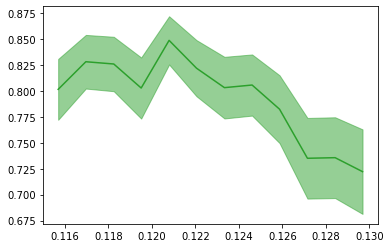

In [30]:
zoom = np.where(np.logical_and(td>0.115, td<0.13))

plt.plot(td[zoom], r[zoom], c='C2')
plt.fill_between(td[zoom], r[zoom]-dr[zoom], r[zoom]+dr[zoom], color='C2', alpha=0.5)
plt.show()

We can roughly take the maximum of ```r``` in this region as our estimate of the period, and the region where ```r+dr``` is greater than this value as the confidence interval for such estimate:

In [ ]:
est = np.argmax(r[zoom])
ci = np.where(r[zoom]+dr[zoom]>r[zoom])

period = td[zoom][est]
period_lo = td[zoom][ci][0] - period
period_up = td[zoom][ci][-1] - period
print('Period: %3.3f (%3.3f +%3.3f) d' % (period, period_lo, period_up))

This is very well agreement with the current best estimate of 0.12053492 d, albeit a lot less precise. We could have modeled the peak of the correlation coefficient in a more sophisticated way, but the better way to improve the estimation is to observe the star through several periods instead of one.

### Fast, Fourier, Transform!

Since the light curve is periodic, it makes sense to describe it in terms of frequencies, using the **Fourier transform**. This can be done with the Fast Fourier Transform (FFT) algorithm, included in SciPy. 

In our specific case, there are at least two caveats to be considered. Firstly, the FFT algorithm assumes that the time sampling is constant, which is only marginally true for our dataset: 

In [ ]:
td_step = (td[1:]-td[:-1]) * 86400
td_med = np.median(td_step)

plot_graph(td[1:], td_step, mode='scatter', xlabel='Time since start [d]', ylabel='Time step [s]')
plt.axhline(td_med)
plt.show()

Secondly and most importantly, the time domain covered by our data is very limited. As a consequence, the frequency domain is severely undersampled, especially in the region where we expect to find the fundamental frequency of the oscillation, $f=1/p\simeq 8$d$^{-1}$ (shaded in the plot):

In [ ]:
from scipy import fftpack as fft

n = len(mag)  # Length of light curve
f = fft.rfftfreq(n, td_med/86400)  # Frequency domain, in d^-1
mag_f = fft.rfft(mag)  # FFT of V mag
mag_s = mag_f**2  # Spectrum of V mag

print(f, len(mag_s))

plot_graph(f, mag_s, mode='scatter', xlabel='Frequency [d^-1]', ylabel='Spectrum of V mag (abs. value)')
plt.axvspan(1/0.116, 1/0.129, alpha=0.2, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-6,1e3)
plt.show()

Just for demonstration purposes, we will artificially extend our time domain by cutting out a single period from the light curve and copy-pasting it onto itself several times. Of course, this is not a good alternative to acquiring more data!

You can see than with 20 repeats the frequency space is much better sampled and a subset of frequencies becomes more relevant:

In [ ]:
cut = 151  # This is where the period ends in our original time series
repeat = 20
magr = mag[:cut]
for i in range(repeat):
    magr = np.append(mag[:cut], magr)  # Extended light curve

nr = len(magr)
tdr = np.linspace(0, nr*td_med/86400, nr)  # Extended time domain, in d
fr = fft.rfftfreq(nr, td_med/86400)
magr_f = fft.rfft(magr)
magr_s = magr_f**2

plot_graph(tdr, magr)
plot_graph(fr, magr_s, mode='scatter', xlabel='Frequency [d^-1]', ylabel='Spectrum of V mag (abs. value)')
plt.axvspan(1/0.116, 1/0.129, alpha=0.2, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-40,1e10)
plt.show()

By cutting off the irrrelevant frequencies and compute the inverse-FFT on the resulting spectrum, we can efficiently smooth the light curve:

In [ ]:
import time

for exp in np.arange(-5,-8,-0.5):
    cutoff = 10**exp
    cutoff_idx = magr_s < magr_s.max()*cutoff
    magr_f_cut = np.copy(magr_f)
    magr_s_cut = np.copy(magr_s)
    magr_f_cut[cutoff_idx] = 0
    magr_s_cut[cutoff_idx] = 0
    magr_cut = fft.irfft(magr_f_cut, nr)
    plot_graph(fr, magr_s, mode='scatter', xlabel='Frequency [d^-1]', ylabel='Spectrum of V mag (abs. value)')
    plot_graph(fr, magr_s_cut, mode='scatter', new=False)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,1e3)
    plt.ylim(1e-40,1e10)
    plot_refresh()
    plt.show()
    
    plot_graph(td, mag, xlabel='Time since start [d]', ylabel='V mag')
    plot_graph(td, magr_cut[:len(mag)], new=False)
    plt.ylim(9.8, 9.1)

    time.sleep(3)
    plot_refresh()
    plt.show()

## Folding our data

An efficient technique to analize periodic data when the series is limited in time is to **fold** the time series onto itself, i.e. converting times into phases. If we don't know the period, we can try and compute different phase series for different test periods in a range, and see which folding gives a better alignment of the features of the phase series (not surprisingly, this happens for a period around 0.12 d in our case):

In [ ]:
mag_ph = mag
td_ph = td

period_range = np.arange(0.01,0.175,0.01)  # Range of test periods
period_chi2r = np.array([])

for i,p in enumerate(period_range):
    ph = 2*np.pi * td_ph/p % (2*np.pi)
    plot_graph(ph, mag_ph, mode='scatter')
    plot_refresh("Test period: %3.2f d" % p)
    time.sleep(0.5)
    plt.show()

We can refine our estimation of the period by scanning the range of test periods around the value that gives the best folding alignment, and computing the **reduced chi-squared** ($\chi^2_r$) between the sections of the phase series that are folded onto each other. We see that $\chi^2_r$ decreases, reaches a minimum very close to 1, and increases again, as the test periods moves through the range:

In [ ]:
bins = 210

def chi2r(obs, mod, err, npar=1):
    chi2 = np.sum((obs-mod)**2/err**2)
    return chi2 /(len(obs)-npar)

period_range = np.arange(0.12,0.123,0.00005)  # Shorter and finer range of test periods
period_chi2r = np.array([])

for p in period_range:
    ph = 2*np.pi * td_ph/p % (2*np.pi)
    
    l = min(np.sum(td_ph<p), np.sum(td_ph>p))
    head = mag_ph[:l]
    tail = np.interp(ph[:l], ph[-l:], mag_ph[-l:])
    period_chi2r = np.append(period_chi2r, chi2r(head,tail,mag_err[:l]))
    
    plot_graph(ph, mag_ph, mode='scatter')
    plot_refresh(r"Test period: %3.5f; $\chi_r^2$: %3.4f" % (p, chi2r(head,tail,mag_err[:l])))
    plt.show()

The best-fit period is the one that gives the minimum $\chi_r^2$ on the phase series, and its 1-$\sigma$ uncertainty is defined by the region where the $\chi_r^2$ is less than $\chi_{r,\mathrm{min}}^2+1$. You can see that with this method we obtain a much better precision than using the Pearson correlation coefficient, as we did before: 

In [ ]:
est = np.argmin(period_chi2r)
ci = np.where(period_chi2r<period_chi2r[est]+1)

chi2r_min = period_chi2r[est]
period = period_range[est]
period_lo = period_range[ci][0] - period
period_up = period_range[ci][-1] - period

plot_graph(period_range, period_chi2r)
plot_graph(period, period_chi2r[est], mode='scatter', new=False)
plt.axhline(chi2r_min, linestyle=':')
plt.axhline(chi2r_min+1, linestyle=':')
plt.axvline(0.12053492, linestyle='--', c='r')  # Best-fit period from literature 
plt.axvspan(period+period_lo, period+period_up, alpha=0.2, color='C0')
plt.show()

print('Period: %3.5f (%3.5f +%3.5f) d' % (period, period_lo, period_up))